In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.utils.data as data_utils

# Set random seed for reproducibility
manualSeed = 666
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  666


In [55]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tqdm
import mat4py
from sklearn import metrics
import logomaker
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import seqlogo
import scipy
import re
from matplotlib import gridspec
import scipy
from sklearn.metrics import auc, average_precision_score
from collections import OrderedDict
import torch.nn as nn
import torch
import joblib
import torch.nn.functional as F
import torch.optim as optim
import os
from joblib import Parallel, delayed
%matplotlib notebook

In [2]:
import pickle as pkl

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class heterodimeric_motif_generator(nn.Module):
    def __init__(self):
        super(heterodimeric_motif_generator, self).__init__()
        self.motif_cnn = nn.Sequential(
            nn.Conv1d(4, 32, 3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 32, 3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Flatten(1, -1),
            nn.Linear(992, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        
        self.add_nz = nn.Sequential(
            nn.Linear(64*2+32+100, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 19)
        )

        self.cnn_generator = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose1d(1, 4, 5),
            nn.BatchNorm1d(4),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(4, 16, 5),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 16, 5),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(16, 4, 5),
            nn.BatchNorm1d(4),
            nn.Sigmoid(),
        )

    def forward(self, nz, motif1, motif2, family_code):
        m1 = self.motif_cnn(motif1.permute(0, 2, 1))
        m2 = self.motif_cnn(motif2.permute(0, 2, 1))
        mp_nz = self.add_nz(torch.cat((m1, m2, nz, family_code), axis=-1))
        # print(mp_nz.unsqueeze(1).size())
        hmotif = self.cnn_generator(mp_nz.unsqueeze(1))
        # print(hmotif.size())
        return hmotif
        # return self.main(input)

In [249]:
m1 = torch.randn((2, 35, 4))
m2 = torch.randn((2, 35, 4))
fcode = torch.rand((2, 100))
nz = torch.randn(2, 32)

In [250]:
motif1.shape

torch.Size([100, 35, 4])

In [251]:
hmg = heterodimeric_motif_generator()
hmg(nz, m1, m2, fcode).size()

torch.Size([2, 4, 35])

In [5]:
class heterodimeric_motif_discriminator(nn.Module):
    def __init__(self):
        super(heterodimeric_motif_discriminator, self).__init__()
        # self.ngpu = ngpu
        self.cnn = nn.Sequential(
            nn.Conv1d(4, 32, 3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, 3),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Conv1d(32, 32, 1),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Flatten(1, -1)
        )
        self.Linear = nn.Sequential(
            nn.Linear(1092, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, motif, family_code):
        cnn_out = self.cnn(motif)
        # print(cnn_out.size(), family_code.size())
        return self.Linear(torch.cat((cnn_out, family_code),dim=1))
    

In [253]:
# Create the generator
netG = heterodimeric_motif_generator().to(device)

# Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netG.apply(weights_init)

# Print the model
print(netG)

heterodimeric_motif_generator(
  (motif_cnn): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=992, out_features=512, bias=True)
    (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=512, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
  )
  (add_nz): Sequential(
    (0): Linear(in_features=260, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=19, b

In [254]:
# Create the Discriminator
netD = heterodimeric_motif_discriminator().to(device)

# Handle multi-gpu if desired
# if (device.type == 'cuda') and (ngpu > 1):
#     netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
# netD.apply(weights_init)

# Print the model
print(netD)

heterodimeric_motif_discriminator(
  (cnn): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (Linear): Sequential(
    (0): Linear(in_features=1092, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=64, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [6]:
torch.cuda.set_device(1)
device = 'cuda'
from sklearn.model_selection import LeaveOneOut
kc_family_list = pkl.load(open("../kc_heterodimer_family.pkl", "rb"))
dimer_names, family_names, family_codes, motif1_codes, motif2_codes, aligned_motif1_codes, aligned_motif2_codes, dimer_codes = pkl.load(open("../leave.one.out.seperatedMotif.twoStage.crxvalidate/seperated_motif_pairs_35Len.pkl", "rb"))

family_codes = family_codes[:, np.newaxis, :]
family_codes = family_codes.repeat(aligned_motif1_codes.shape[1], 1)
aligned_motifpairs = np.concatenate([aligned_motif1_codes, aligned_motif2_codes, family_codes],axis=-1)

# wa_mp_name, wa_mp_family, wa_mp_code, wa_mp_dimer_code = pkl.load(open("./whole_algined_motifpairs/whole_aligned_mp_allFam.pkl", "rb"))
found_mp_name, found_mp_family, found_mp_code, true_mp_code, found_mp_dimer_code = pkl.load(open("../generated_motifpairs/found_best_aligned_mp_allFam_correctedFamilyName.pkl", "rb"))
#  dimer_names, family_names, motif_pair_codes, actual_dimer_codes = pkl.load(open("corrected_motifpair_dimer_dataset.pkl", "rb"))

aligned_motifpairs = true_mp_code
family_names = found_mp_family
dimer_names = found_mp_name
dimer_codes = found_mp_dimer_code

unique_dnames = []
for dn in dimer_names:
    unique_dnames.append("_".join(dn.split("_")[:2]))

unique_dnames = np.array(unique_dnames)
print(len(set(unique_dnames)))

313


In [7]:
test_hm = 'FLI1_FOXI1'
family_onehot_encode = pkl.load(open("./kc_heterodimer_family_all614dimers_upper_oneHotDict.pkl", "rb"))

In [8]:
family_codes = np.squeeze(np.array([family_onehot_encode[fam] for fam in family_names]))
motif1_codes = aligned_motifpairs[:, :, :4]
motif2_codes = aligned_motifpairs[:, :, 4:8]

In [9]:
motif1_codes.shape

(614, 35, 4)

In [11]:
test_index = unique_dnames == test_hm
train_index = unique_dnames != test_hm
    
test_family_name = family_names[test_index]
test_dimer_name = dimer_names[test_index]
test_unique_dname = unique_dnames[test_index]

reversed_fam = test_family_name[0].split("_")[1] + "_" + test_family_name[0].split("_")[0]
tune_index = np.arange(len(dimer_names))[np.array(family_names == test_family_name[0])*np.array(dimer_names != test_dimer_name[0])]
tune_index = np.concatenate([tune_index, np.arange(len(dimer_names))[np.array(family_names == reversed_fam)*np.array(dimer_names != test_dimer_name[0])]])

fold_name = test_family_name[0] + "-"+ "-".join(test_dimer_name)
print("-"*20, test_family_name, test_dimer_name, "-"*20)

test_family_code = family_codes[test_index]
train_family_code = family_codes[train_index]

train_motif1_code, train_motif2_code =  motif1_codes[train_index], motif2_codes[train_index]
test_motif1_code, test_motif2_code = motif1_codes[test_index], motif2_codes[test_index]
train_hmp_code = dimer_codes[train_index]
test_hmp_code = dimer_codes[test_index]

-------------------- ['FOX_ETS' 'FOX_ETS' 'FOX_ETS' 'FOX_ETS'] ['FLI1_FOXI1' 'FLI1_FOXI1_2' 'FLI1_FOXI1_3' 'FLI1_FOXI1_4'] --------------------


In [24]:
b_size = 100
train = data_utils.TensorDataset(torch.from_numpy(train_motif1_code),torch.from_numpy(train_motif2_code), torch.from_numpy(train_family_code), torch.from_numpy(train_hmp_code))
trainloader = data_utils.DataLoader(train, batch_size=b_size, shuffle=True, num_workers = 1)

In [28]:
batch_size = 2
beta1 = 0.5
# Initialize BCELoss function
criterion = nn.BCELoss()
batch_size = 100

netG = heterodimeric_motif_generator().to(device)
netD = heterodimeric_motif_discriminator().to(device)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, 32)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.AdamW(netD.parameters(), lr=0.005)
optimizerG = optim.AdamW(netG.parameters(), lr=0.005)

In [29]:
# Training Loop
device = 'cuda:1'
num_epochs = 2000
fixed_noise = torch.randn(10, 32)
# Lists to keep track of progress
# img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        motif1 = data[0].float().to(device)
        motif2 = data[1].float().to(device)
        family_c = data[2].float().to(device)
        heter_motif = data[3].float().to(device).permute(0, 2, 1)
        
        b_size = motif1.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(heter_motif, family_c).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        # Generate batch of latent vectors
        
        noise = torch.randn(b_size, 32).float().to(device)
 
        # Generate fake image batch with G
        fake_heter_motif = netG(noise, motif1, motif2, family_c)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake_heter_motif.detach(), family_c).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_heter_motif, family_c).view(-1)
        
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
#         if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#             with torch.no_grad():
#                 fake = netG(fixed_noise).detach().cpu()
#             # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        iters += 1
        break

Starting Training Loop...
[0/2000][0/7]	Loss_D: 1.4424	Loss_G: 0.7075	D(x): 0.5741	D(G(z)): 0.5705 / 0.5216
[1/2000][0/7]	Loss_D: 1.4772	Loss_G: 0.7518	D(x): 0.5406	D(G(z)): 0.5401 / 0.4875
[2/2000][0/7]	Loss_D: 1.4021	Loss_G: 0.7655	D(x): 0.5199	D(G(z)): 0.5104 / 0.4702
[3/2000][0/7]	Loss_D: 1.3956	Loss_G: 0.7801	D(x): 0.5032	D(G(z)): 0.4927 / 0.4627
[4/2000][0/7]	Loss_D: 1.3662	Loss_G: 0.7995	D(x): 0.4929	D(G(z)): 0.4737 / 0.4519
[5/2000][0/7]	Loss_D: 1.3569	Loss_G: 0.7971	D(x): 0.4887	D(G(z)): 0.4668 / 0.4526
[6/2000][0/7]	Loss_D: 1.3469	Loss_G: 0.7937	D(x): 0.4890	D(G(z)): 0.4627 / 0.4544
[7/2000][0/7]	Loss_D: 1.3349	Loss_G: 0.7880	D(x): 0.4931	D(G(z)): 0.4615 / 0.4565
[8/2000][0/7]	Loss_D: 1.3243	Loss_G: 0.7695	D(x): 0.5061	D(G(z)): 0.4694 / 0.4648
[9/2000][0/7]	Loss_D: 1.3183	Loss_G: 0.7591	D(x): 0.5107	D(G(z)): 0.4717 / 0.4694
[10/2000][0/7]	Loss_D: 1.3205	Loss_G: 0.7409	D(x): 0.5200	D(G(z)): 0.4804 / 0.4781
[11/2000][0/7]	Loss_D: 1.2984	Loss_G: 0.7433	D(x): 0.5324	D(G(z)): 0.48

[99/2000][0/7]	Loss_D: 0.2915	Loss_G: 2.3754	D(x): 0.8756	D(G(z)): 0.1411 / 0.1053
[100/2000][0/7]	Loss_D: 0.3296	Loss_G: 2.3902	D(x): 0.8758	D(G(z)): 0.1648 / 0.1145
[101/2000][0/7]	Loss_D: 0.3031	Loss_G: 2.5483	D(x): 0.8579	D(G(z)): 0.1328 / 0.0955
[102/2000][0/7]	Loss_D: 0.2994	Loss_G: 2.7100	D(x): 0.8580	D(G(z)): 0.1159 / 0.0842
[103/2000][0/7]	Loss_D: 0.2632	Loss_G: 2.7336	D(x): 0.8779	D(G(z)): 0.1201 / 0.0850
[104/2000][0/7]	Loss_D: 0.2376	Loss_G: 2.8555	D(x): 0.9007	D(G(z)): 0.1125 / 0.0834
[105/2000][0/7]	Loss_D: 0.2419	Loss_G: 2.8141	D(x): 0.9077	D(G(z)): 0.1267 / 0.0805
[106/2000][0/7]	Loss_D: 0.2476	Loss_G: 2.8292	D(x): 0.8944	D(G(z)): 0.1129 / 0.0724
[107/2000][0/7]	Loss_D: 0.2046	Loss_G: 2.8409	D(x): 0.9078	D(G(z)): 0.0991 / 0.0812
[108/2000][0/7]	Loss_D: 0.3052	Loss_G: 2.7907	D(x): 0.8631	D(G(z)): 0.1220 / 0.1010
[109/2000][0/7]	Loss_D: 0.3573	Loss_G: 2.6392	D(x): 0.8666	D(G(z)): 0.1501 / 0.1130
[110/2000][0/7]	Loss_D: 0.2751	Loss_G: 2.8188	D(x): 0.8709	D(G(z)): 0.1192 / 

[197/2000][0/7]	Loss_D: 0.0427	Loss_G: 4.1724	D(x): 0.9755	D(G(z)): 0.0176 / 0.0159
[198/2000][0/7]	Loss_D: 0.0377	Loss_G: 3.8873	D(x): 0.9861	D(G(z)): 0.0232 / 0.0224
[199/2000][0/7]	Loss_D: 0.0626	Loss_G: 4.1055	D(x): 0.9569	D(G(z)): 0.0179 / 0.0176
[200/2000][0/7]	Loss_D: 0.0424	Loss_G: 3.7467	D(x): 0.9859	D(G(z)): 0.0278 / 0.0272
[201/2000][0/7]	Loss_D: 0.0527	Loss_G: 3.5714	D(x): 0.9822	D(G(z)): 0.0340 / 0.0332
[202/2000][0/7]	Loss_D: 0.0375	Loss_G: 3.9601	D(x): 0.9850	D(G(z)): 0.0221 / 0.0216
[203/2000][0/7]	Loss_D: 0.0310	Loss_G: 4.2490	D(x): 0.9850	D(G(z)): 0.0155 / 0.0152
[204/2000][0/7]	Loss_D: 0.0297	Loss_G: 4.2887	D(x): 0.9853	D(G(z)): 0.0147 / 0.0145
[205/2000][0/7]	Loss_D: 0.0448	Loss_G: 4.1233	D(x): 0.9766	D(G(z)): 0.0181 / 0.0178
[206/2000][0/7]	Loss_D: 0.0261	Loss_G: 4.4046	D(x): 0.9867	D(G(z)): 0.0126 / 0.0125
[207/2000][0/7]	Loss_D: 0.0356	Loss_G: 4.3747	D(x): 0.9812	D(G(z)): 0.0130 / 0.0130
[208/2000][0/7]	Loss_D: 0.0304	Loss_G: 4.2601	D(x): 0.9848	D(G(z)): 0.0149 /

[295/2000][0/7]	Loss_D: 0.1593	Loss_G: 4.2087	D(x): 0.9831	D(G(z)): 0.1206 / 0.0915
[296/2000][0/7]	Loss_D: 0.0871	Loss_G: 4.7605	D(x): 0.9715	D(G(z)): 0.0554 / 0.0317
[297/2000][0/7]	Loss_D: 0.1082	Loss_G: 5.6572	D(x): 0.9605	D(G(z)): 0.0634 / 0.0303
[298/2000][0/7]	Loss_D: 0.1663	Loss_G: 5.3727	D(x): 0.9183	D(G(z)): 0.0581 / 0.0267
[299/2000][0/7]	Loss_D: 0.1511	Loss_G: 5.2718	D(x): 0.9015	D(G(z)): 0.0392 / 0.0266
[300/2000][0/7]	Loss_D: 0.1309	Loss_G: 5.0583	D(x): 0.9623	D(G(z)): 0.0525 / 0.0152
[301/2000][0/7]	Loss_D: 0.0968	Loss_G: 5.1878	D(x): 0.9359	D(G(z)): 0.0278 / 0.0176
[302/2000][0/7]	Loss_D: 0.1048	Loss_G: 4.9839	D(x): 0.9384	D(G(z)): 0.0386 / 0.0292
[303/2000][0/7]	Loss_D: 0.1252	Loss_G: 4.9026	D(x): 0.9261	D(G(z)): 0.0407 / 0.0301
[304/2000][0/7]	Loss_D: 0.1000	Loss_G: 4.9782	D(x): 0.9396	D(G(z)): 0.0349 / 0.0261
[305/2000][0/7]	Loss_D: 0.1645	Loss_G: 4.7547	D(x): 0.8842	D(G(z)): 0.0331 / 0.0272
[306/2000][0/7]	Loss_D: 0.1056	Loss_G: 4.3470	D(x): 0.9393	D(G(z)): 0.0405 /

[393/2000][0/7]	Loss_D: 0.0841	Loss_G: 4.6296	D(x): 0.9836	D(G(z)): 0.0627 / 0.0315
[394/2000][0/7]	Loss_D: 0.0677	Loss_G: 4.3893	D(x): 0.9846	D(G(z)): 0.0490 / 0.0496
[395/2000][0/7]	Loss_D: 0.1001	Loss_G: 4.9031	D(x): 0.9761	D(G(z)): 0.0650 / 0.0169
[396/2000][0/7]	Loss_D: 0.0562	Loss_G: 4.8629	D(x): 0.9798	D(G(z)): 0.0339 / 0.0284
[397/2000][0/7]	Loss_D: 0.0667	Loss_G: 4.9771	D(x): 0.9796	D(G(z)): 0.0390 / 0.0304
[398/2000][0/7]	Loss_D: 0.0566	Loss_G: 5.2070	D(x): 0.9813	D(G(z)): 0.0361 / 0.0432
[399/2000][0/7]	Loss_D: 0.1013	Loss_G: 5.1870	D(x): 0.9707	D(G(z)): 0.0666 / 0.0484
[400/2000][0/7]	Loss_D: 0.1121	Loss_G: 5.4909	D(x): 0.9240	D(G(z)): 0.0304 / 0.0207
[401/2000][0/7]	Loss_D: 0.0602	Loss_G: 5.7310	D(x): 0.9779	D(G(z)): 0.0365 / 0.0216
[402/2000][0/7]	Loss_D: 0.0844	Loss_G: 5.7152	D(x): 0.9550	D(G(z)): 0.0316 / 0.0190
[403/2000][0/7]	Loss_D: 0.0464	Loss_G: 5.7986	D(x): 0.9789	D(G(z)): 0.0238 / 0.0131
[404/2000][0/7]	Loss_D: 0.0447	Loss_G: 6.0051	D(x): 0.9739	D(G(z)): 0.0141 /

[491/2000][0/7]	Loss_D: 0.0277	Loss_G: 4.8778	D(x): 0.9867	D(G(z)): 0.0142 / 0.0124
[492/2000][0/7]	Loss_D: 0.0317	Loss_G: 4.5488	D(x): 0.9892	D(G(z)): 0.0199 / 0.0144
[493/2000][0/7]	Loss_D: 0.0457	Loss_G: 4.3964	D(x): 0.9743	D(G(z)): 0.0190 / 0.0168
[494/2000][0/7]	Loss_D: 0.0407	Loss_G: 4.1060	D(x): 0.9867	D(G(z)): 0.0267 / 0.0222
[495/2000][0/7]	Loss_D: 0.0359	Loss_G: 4.1736	D(x): 0.9920	D(G(z)): 0.0271 / 0.0232
[496/2000][0/7]	Loss_D: 0.0510	Loss_G: 3.9086	D(x): 0.9880	D(G(z)): 0.0376 / 0.0305
[497/2000][0/7]	Loss_D: 0.0719	Loss_G: 3.5269	D(x): 0.9901	D(G(z)): 0.0588 / 0.0401
[498/2000][0/7]	Loss_D: 0.0850	Loss_G: 3.7113	D(x): 0.9922	D(G(z)): 0.0687 / 0.0437
[499/2000][0/7]	Loss_D: 0.0889	Loss_G: 3.9215	D(x): 0.9864	D(G(z)): 0.0659 / 0.0346
[500/2000][0/7]	Loss_D: 0.0656	Loss_G: 4.0582	D(x): 0.9891	D(G(z)): 0.0524 / 0.0364
[501/2000][0/7]	Loss_D: 0.0703	Loss_G: 4.3590	D(x): 0.9728	D(G(z)): 0.0406 / 0.0232
[502/2000][0/7]	Loss_D: 0.0616	Loss_G: 4.5750	D(x): 0.9826	D(G(z)): 0.0417 /

[589/2000][0/7]	Loss_D: 0.0461	Loss_G: 4.9626	D(x): 0.9819	D(G(z)): 0.0265 / 0.0196
[590/2000][0/7]	Loss_D: 0.0632	Loss_G: 5.3122	D(x): 0.9505	D(G(z)): 0.0097 / 0.0083
[591/2000][0/7]	Loss_D: 0.0407	Loss_G: 5.3878	D(x): 0.9686	D(G(z)): 0.0083 / 0.0069
[592/2000][0/7]	Loss_D: 0.0275	Loss_G: 5.3746	D(x): 0.9854	D(G(z)): 0.0126 / 0.0099
[593/2000][0/7]	Loss_D: 0.0353	Loss_G: 5.6082	D(x): 0.9742	D(G(z)): 0.0086 / 0.0058
[594/2000][0/7]	Loss_D: 0.0418	Loss_G: 5.4151	D(x): 0.9792	D(G(z)): 0.0202 / 0.0152
[595/2000][0/7]	Loss_D: 0.0320	Loss_G: 5.6856	D(x): 0.9777	D(G(z)): 0.0074 / 0.0054
[596/2000][0/7]	Loss_D: 0.0462	Loss_G: 5.3978	D(x): 0.9737	D(G(z)): 0.0189 / 0.0151
[597/2000][0/7]	Loss_D: 0.0274	Loss_G: 5.6552	D(x): 0.9829	D(G(z)): 0.0099 / 0.0079
[598/2000][0/7]	Loss_D: 0.0710	Loss_G: 5.4723	D(x): 0.9686	D(G(z)): 0.0167 / 0.0156
[599/2000][0/7]	Loss_D: 0.1415	Loss_G: 5.7377	D(x): 0.8897	D(G(z)): 0.0129 / 0.0119
[600/2000][0/7]	Loss_D: 0.0183	Loss_G: 5.8003	D(x): 0.9889	D(G(z)): 0.0071 /

[687/2000][0/7]	Loss_D: 0.0364	Loss_G: 4.8727	D(x): 0.9902	D(G(z)): 0.0252 / 0.0096
[688/2000][0/7]	Loss_D: 0.0238	Loss_G: 5.2762	D(x): 0.9860	D(G(z)): 0.0095 / 0.0092
[689/2000][0/7]	Loss_D: 0.0262	Loss_G: 5.2096	D(x): 0.9902	D(G(z)): 0.0160 / 0.0153
[690/2000][0/7]	Loss_D: 0.0312	Loss_G: 5.4458	D(x): 0.9840	D(G(z)): 0.0148 / 0.0145
[691/2000][0/7]	Loss_D: 0.0461	Loss_G: 5.2396	D(x): 0.9786	D(G(z)): 0.0210 / 0.0194
[692/2000][0/7]	Loss_D: 0.1003	Loss_G: 5.1101	D(x): 0.9311	D(G(z)): 0.0258 / 0.0208
[693/2000][0/7]	Loss_D: 0.0258	Loss_G: 5.1391	D(x): 0.9935	D(G(z)): 0.0188 / 0.0139
[694/2000][0/7]	Loss_D: 0.0236	Loss_G: 5.1209	D(x): 0.9898	D(G(z)): 0.0131 / 0.0099
[695/2000][0/7]	Loss_D: 0.0205	Loss_G: 5.1853	D(x): 0.9910	D(G(z)): 0.0112 / 0.0092
[696/2000][0/7]	Loss_D: 0.0237	Loss_G: 5.4707	D(x): 0.9861	D(G(z)): 0.0095 / 0.0089
[697/2000][0/7]	Loss_D: 0.0370	Loss_G: 5.4017	D(x): 0.9794	D(G(z)): 0.0153 / 0.0089
[698/2000][0/7]	Loss_D: 0.0177	Loss_G: 5.6700	D(x): 0.9902	D(G(z)): 0.0076 /

[785/2000][0/7]	Loss_D: 0.2284	Loss_G: 5.7378	D(x): 0.8259	D(G(z)): 0.0196 / 0.0132
[786/2000][0/7]	Loss_D: 0.1082	Loss_G: 5.3575	D(x): 0.9174	D(G(z)): 0.0139 / 0.0145
[787/2000][0/7]	Loss_D: 0.1281	Loss_G: 4.5493	D(x): 0.9258	D(G(z)): 0.0155 / 0.0145
[788/2000][0/7]	Loss_D: 0.0451	Loss_G: 4.5630	D(x): 0.9779	D(G(z)): 0.0217 / 0.0227
[789/2000][0/7]	Loss_D: 0.1905	Loss_G: 3.9048	D(x): 0.9848	D(G(z)): 0.1312 / 0.0575
[790/2000][0/7]	Loss_D: 0.0942	Loss_G: 4.7703	D(x): 0.9832	D(G(z)): 0.0719 / 0.0337
[791/2000][0/7]	Loss_D: 0.0938	Loss_G: 4.7144	D(x): 0.9407	D(G(z)): 0.0295 / 0.0144
[792/2000][0/7]	Loss_D: 0.0760	Loss_G: 5.5275	D(x): 0.9541	D(G(z)): 0.0169 / 0.0126
[793/2000][0/7]	Loss_D: 0.1154	Loss_G: 5.4175	D(x): 0.9074	D(G(z)): 0.0110 / 0.0106
[794/2000][0/7]	Loss_D: 0.1479	Loss_G: 5.2742	D(x): 0.8943	D(G(z)): 0.0144 / 0.0196
[795/2000][0/7]	Loss_D: 0.0676	Loss_G: 5.4205	D(x): 0.9649	D(G(z)): 0.0294 / 0.0348
[796/2000][0/7]	Loss_D: 0.0481	Loss_G: 4.8711	D(x): 0.9843	D(G(z)): 0.0312 /

[883/2000][0/7]	Loss_D: 0.0128	Loss_G: 6.3701	D(x): 0.9907	D(G(z)): 0.0034 / 0.0028
[884/2000][0/7]	Loss_D: 0.0065	Loss_G: 6.5989	D(x): 0.9963	D(G(z)): 0.0028 / 0.0026
[885/2000][0/7]	Loss_D: 0.0063	Loss_G: 6.6620	D(x): 0.9962	D(G(z)): 0.0026 / 0.0023
[886/2000][0/7]	Loss_D: 0.0077	Loss_G: 6.5477	D(x): 0.9952	D(G(z)): 0.0029 / 0.0026
[887/2000][0/7]	Loss_D: 0.0054	Loss_G: 6.6375	D(x): 0.9971	D(G(z)): 0.0025 / 0.0021
[888/2000][0/7]	Loss_D: 0.0060	Loss_G: 6.4032	D(x): 0.9968	D(G(z)): 0.0028 / 0.0025
[889/2000][0/7]	Loss_D: 0.0073	Loss_G: 6.5164	D(x): 0.9951	D(G(z)): 0.0024 / 0.0021
[890/2000][0/7]	Loss_D: 0.0077	Loss_G: 6.7411	D(x): 0.9941	D(G(z)): 0.0018 / 0.0016
[891/2000][0/7]	Loss_D: 0.0084	Loss_G: 6.3774	D(x): 0.9944	D(G(z)): 0.0026 / 0.0023
[892/2000][0/7]	Loss_D: 0.0072	Loss_G: 6.1125	D(x): 0.9970	D(G(z)): 0.0042 / 0.0039
[893/2000][0/7]	Loss_D: 0.0035	Loss_G: 7.1727	D(x): 0.9981	D(G(z)): 0.0016 / 0.0014
[894/2000][0/7]	Loss_D: 0.0094	Loss_G: 6.2789	D(x): 0.9955	D(G(z)): 0.0048 /

[981/2000][0/7]	Loss_D: 0.0452	Loss_G: 7.1352	D(x): 0.9829	D(G(z)): 0.0234 / 0.0152
[982/2000][0/7]	Loss_D: 0.0605	Loss_G: 7.1746	D(x): 0.9608	D(G(z)): 0.0188 / 0.0113
[983/2000][0/7]	Loss_D: 0.0503	Loss_G: 7.3138	D(x): 0.9671	D(G(z)): 0.0124 / 0.0060
[984/2000][0/7]	Loss_D: 0.0110	Loss_G: 7.0995	D(x): 0.9961	D(G(z)): 0.0071 / 0.0051
[985/2000][0/7]	Loss_D: 0.0495	Loss_G: 6.1823	D(x): 0.9764	D(G(z)): 0.0243 / 0.0137
[986/2000][0/7]	Loss_D: 0.0608	Loss_G: 6.1051	D(x): 0.9898	D(G(z)): 0.0436 / 0.0104
[987/2000][0/7]	Loss_D: 0.0168	Loss_G: 6.3659	D(x): 0.9940	D(G(z)): 0.0106 / 0.0086
[988/2000][0/7]	Loss_D: 0.0202	Loss_G: 6.3979	D(x): 0.9935	D(G(z)): 0.0125 / 0.0099
[989/2000][0/7]	Loss_D: 0.0425	Loss_G: 6.7513	D(x): 0.9665	D(G(z)): 0.0070 / 0.0063
[990/2000][0/7]	Loss_D: 0.0674	Loss_G: 6.3387	D(x): 0.9701	D(G(z)): 0.0305 / 0.0190
[991/2000][0/7]	Loss_D: 0.0689	Loss_G: 6.1764	D(x): 0.9932	D(G(z)): 0.0563 / 0.0188
[992/2000][0/7]	Loss_D: 0.2187	Loss_G: 6.5321	D(x): 0.9891	D(G(z)): 0.0606 /

[1078/2000][0/7]	Loss_D: 0.0187	Loss_G: 7.6223	D(x): 0.9893	D(G(z)): 0.0078 / 0.0076
[1079/2000][0/7]	Loss_D: 0.0080	Loss_G: 7.8513	D(x): 0.9964	D(G(z)): 0.0043 / 0.0041
[1080/2000][0/7]	Loss_D: 0.4478	Loss_G: 8.1332	D(x): 0.7584	D(G(z)): 0.0051 / 0.0051
[1081/2000][0/7]	Loss_D: 0.0089	Loss_G: 8.1144	D(x): 0.9943	D(G(z)): 0.0032 / 0.0032
[1082/2000][0/7]	Loss_D: 1.5039	Loss_G: 6.9508	D(x): 0.6217	D(G(z)): 0.0068 / 0.0060
[1083/2000][0/7]	Loss_D: 0.0371	Loss_G: 6.1554	D(x): 0.9816	D(G(z)): 0.0170 / 0.0169
[1084/2000][0/7]	Loss_D: 0.1920	Loss_G: 5.6127	D(x): 0.8895	D(G(z)): 0.0093 / 0.0105
[1085/2000][0/7]	Loss_D: 0.0135	Loss_G: 5.4123	D(x): 0.9951	D(G(z)): 0.0085 / 0.0089
[1086/2000][0/7]	Loss_D: 0.0278	Loss_G: 4.6296	D(x): 0.9896	D(G(z)): 0.0171 / 0.0175
[1087/2000][0/7]	Loss_D: 0.0875	Loss_G: 4.2447	D(x): 0.9441	D(G(z)): 0.0238 / 0.0239
[1088/2000][0/7]	Loss_D: 0.0721	Loss_G: 4.2916	D(x): 0.9548	D(G(z)): 0.0219 / 0.0208
[1089/2000][0/7]	Loss_D: 0.0738	Loss_G: 4.1676	D(x): 0.9644	D(G(z

[1175/2000][0/7]	Loss_D: 0.0054	Loss_G: 6.0495	D(x): 0.9990	D(G(z)): 0.0045 / 0.0041
[1176/2000][0/7]	Loss_D: 0.0144	Loss_G: 6.0790	D(x): 0.9903	D(G(z)): 0.0046 / 0.0042
[1177/2000][0/7]	Loss_D: 0.0080	Loss_G: 5.7675	D(x): 0.9985	D(G(z)): 0.0065 / 0.0058
[1178/2000][0/7]	Loss_D: 0.0106	Loss_G: 6.3868	D(x): 0.9978	D(G(z)): 0.0082 / 0.0066
[1179/2000][0/7]	Loss_D: 0.0079	Loss_G: 6.3580	D(x): 0.9975	D(G(z)): 0.0053 / 0.0044
[1180/2000][0/7]	Loss_D: 0.0086	Loss_G: 6.2090	D(x): 0.9969	D(G(z)): 0.0054 / 0.0040
[1181/2000][0/7]	Loss_D: 0.0074	Loss_G: 6.1120	D(x): 0.9977	D(G(z)): 0.0050 / 0.0037
[1182/2000][0/7]	Loss_D: 0.0097	Loss_G: 5.9247	D(x): 0.9977	D(G(z)): 0.0073 / 0.0048
[1183/2000][0/7]	Loss_D: 0.0230	Loss_G: 6.3575	D(x): 0.9934	D(G(z)): 0.0139 / 0.0039
[1184/2000][0/7]	Loss_D: 0.0361	Loss_G: 6.6206	D(x): 0.9864	D(G(z)): 0.0029 / 0.0028
[1185/2000][0/7]	Loss_D: 0.0054	Loss_G: 6.1150	D(x): 0.9984	D(G(z)): 0.0037 / 0.0035
[1186/2000][0/7]	Loss_D: 0.0070	Loss_G: 6.0501	D(x): 0.9979	D(G(z

[1272/2000][0/7]	Loss_D: 0.0103	Loss_G: 7.3377	D(x): 0.9924	D(G(z)): 0.0027 / 0.0021
[1273/2000][0/7]	Loss_D: 0.0132	Loss_G: 6.7997	D(x): 0.9942	D(G(z)): 0.0073 / 0.0049
[1274/2000][0/7]	Loss_D: 0.0134	Loss_G: 6.6075	D(x): 0.9966	D(G(z)): 0.0099 / 0.0068
[1275/2000][0/7]	Loss_D: 0.0167	Loss_G: 6.8209	D(x): 0.9961	D(G(z)): 0.0123 / 0.0063
[1276/2000][0/7]	Loss_D: 0.0332	Loss_G: 6.9219	D(x): 0.9809	D(G(z)): 0.0053 / 0.0043
[1277/2000][0/7]	Loss_D: 0.0201	Loss_G: 6.9884	D(x): 0.9843	D(G(z)): 0.0034 / 0.0032
[1278/2000][0/7]	Loss_D: 0.0199	Loss_G: 6.5199	D(x): 0.9868	D(G(z)): 0.0059 / 0.0053
[1279/2000][0/7]	Loss_D: 0.0204	Loss_G: 6.5226	D(x): 0.9859	D(G(z)): 0.0060 / 0.0055
[1280/2000][0/7]	Loss_D: 0.0115	Loss_G: 6.3838	D(x): 0.9950	D(G(z)): 0.0065 / 0.0059
[1281/2000][0/7]	Loss_D: 0.0084	Loss_G: 6.9121	D(x): 0.9959	D(G(z)): 0.0043 / 0.0041
[1282/2000][0/7]	Loss_D: 0.0136	Loss_G: 6.2414	D(x): 0.9936	D(G(z)): 0.0071 / 0.0061
[1283/2000][0/7]	Loss_D: 0.0130	Loss_G: 6.2974	D(x): 0.9934	D(G(z

[1369/2000][0/7]	Loss_D: 0.0036	Loss_G: 6.4846	D(x): 0.9991	D(G(z)): 0.0027 / 0.0023
[1370/2000][0/7]	Loss_D: 0.0072	Loss_G: 6.3021	D(x): 0.9975	D(G(z)): 0.0046 / 0.0033
[1371/2000][0/7]	Loss_D: 0.0082	Loss_G: 6.1471	D(x): 0.9974	D(G(z)): 0.0056 / 0.0044
[1372/2000][0/7]	Loss_D: 0.0072	Loss_G: 6.0533	D(x): 0.9982	D(G(z)): 0.0053 / 0.0038
[1373/2000][0/7]	Loss_D: 0.0063	Loss_G: 6.1111	D(x): 0.9988	D(G(z)): 0.0050 / 0.0035
[1374/2000][0/7]	Loss_D: 0.0109	Loss_G: 5.9955	D(x): 0.9981	D(G(z)): 0.0089 / 0.0046
[1375/2000][0/7]	Loss_D: 0.0097	Loss_G: 5.8109	D(x): 0.9989	D(G(z)): 0.0085 / 0.0057
[1376/2000][0/7]	Loss_D: 0.0152	Loss_G: 6.0278	D(x): 0.9958	D(G(z)): 0.0103 / 0.0048
[1377/2000][0/7]	Loss_D: 0.0058	Loss_G: 6.6106	D(x): 0.9988	D(G(z)): 0.0046 / 0.0035
[1378/2000][0/7]	Loss_D: 0.0121	Loss_G: 6.5227	D(x): 0.9979	D(G(z)): 0.0096 / 0.0039
[1379/2000][0/7]	Loss_D: 0.0333	Loss_G: 6.3445	D(x): 0.9985	D(G(z)): 0.0277 / 0.0053
[1380/2000][0/7]	Loss_D: 0.0088	Loss_G: 6.3966	D(x): 0.9970	D(G(z

[1466/2000][0/7]	Loss_D: 0.0244	Loss_G: 7.2400	D(x): 0.9807	D(G(z)): 0.0042 / 0.0055
[1467/2000][0/7]	Loss_D: 0.0877	Loss_G: 6.7896	D(x): 0.9381	D(G(z)): 0.0123 / 0.0089
[1468/2000][0/7]	Loss_D: 0.0379	Loss_G: 6.3129	D(x): 0.9838	D(G(z)): 0.0204 / 0.0129
[1469/2000][0/7]	Loss_D: 0.0522	Loss_G: 6.0805	D(x): 0.9893	D(G(z)): 0.0371 / 0.0224
[1470/2000][0/7]	Loss_D: 0.0477	Loss_G: 6.1595	D(x): 0.9967	D(G(z)): 0.0373 / 0.0156
[1471/2000][0/7]	Loss_D: 0.0479	Loss_G: 5.8365	D(x): 0.9928	D(G(z)): 0.0380 / 0.0181
[1472/2000][0/7]	Loss_D: 0.0656	Loss_G: 6.2343	D(x): 0.9820	D(G(z)): 0.0422 / 0.0100
[1473/2000][0/7]	Loss_D: 0.0554	Loss_G: 6.3450	D(x): 0.9938	D(G(z)): 0.0468 / 0.0089
[1474/2000][0/7]	Loss_D: 0.0608	Loss_G: 7.3838	D(x): 0.9894	D(G(z)): 0.0461 / 0.0056
[1475/2000][0/7]	Loss_D: 0.0619	Loss_G: 7.2080	D(x): 0.9655	D(G(z)): 0.0237 / 0.0049
[1476/2000][0/7]	Loss_D: 0.1828	Loss_G: 7.5139	D(x): 0.8847	D(G(z)): 0.0084 / 0.0024
[1477/2000][0/7]	Loss_D: 0.0205	Loss_G: 7.4126	D(x): 0.9863	D(G(z

[1563/2000][0/7]	Loss_D: 0.1117	Loss_G: 10.7553	D(x): 0.9433	D(G(z)): 0.0229 / 0.0161
[1564/2000][0/7]	Loss_D: 0.0905	Loss_G: 10.5733	D(x): 0.9457	D(G(z)): 0.0248 / 0.0178
[1565/2000][0/7]	Loss_D: 0.0265	Loss_G: 10.1344	D(x): 0.9926	D(G(z)): 0.0183 / 0.0128
[1566/2000][0/7]	Loss_D: 0.0205	Loss_G: 10.5656	D(x): 0.9893	D(G(z)): 0.0093 / 0.0070
[1567/2000][0/7]	Loss_D: 0.0155	Loss_G: 10.4204	D(x): 0.9933	D(G(z)): 0.0086 / 0.0066
[1568/2000][0/7]	Loss_D: 0.0221	Loss_G: 9.5345	D(x): 0.9956	D(G(z)): 0.0173 / 0.0120
[1569/2000][0/7]	Loss_D: 0.0349	Loss_G: 9.2792	D(x): 0.9862	D(G(z)): 0.0196 / 0.0122
[1570/2000][0/7]	Loss_D: 0.0252	Loss_G: 9.0091	D(x): 0.9958	D(G(z)): 0.0201 / 0.0118
[1571/2000][0/7]	Loss_D: 0.0148	Loss_G: 9.4485	D(x): 0.9973	D(G(z)): 0.0116 / 0.0067
[1572/2000][0/7]	Loss_D: 0.0131	Loss_G: 8.6428	D(x): 0.9945	D(G(z)): 0.0073 / 0.0082
[1573/2000][0/7]	Loss_D: 0.0410	Loss_G: 8.8170	D(x): 0.9973	D(G(z)): 0.0314 / 0.0057
[1574/2000][0/7]	Loss_D: 0.0532	Loss_G: 8.7201	D(x): 0.9925	

[1660/2000][0/7]	Loss_D: 0.0380	Loss_G: 7.2028	D(x): 0.9935	D(G(z)): 0.0306 / 0.0251
[1661/2000][0/7]	Loss_D: 0.0596	Loss_G: 7.4044	D(x): 0.9863	D(G(z)): 0.0435 / 0.0341
[1662/2000][0/7]	Loss_D: 0.1042	Loss_G: 8.2255	D(x): 0.9935	D(G(z)): 0.0749 / 0.0547
[1663/2000][0/7]	Loss_D: 0.0914	Loss_G: 6.7153	D(x): 0.9964	D(G(z)): 0.0819 / 0.0563
[1664/2000][0/7]	Loss_D: 0.0959	Loss_G: 7.2461	D(x): 0.9961	D(G(z)): 0.0822 / 0.0506
[1665/2000][0/7]	Loss_D: 0.1017	Loss_G: 7.1024	D(x): 0.9971	D(G(z)): 0.0920 / 0.0554
[1666/2000][0/7]	Loss_D: 0.0596	Loss_G: 7.2780	D(x): 0.9879	D(G(z)): 0.0445 / 0.0254
[1667/2000][0/7]	Loss_D: 0.0638	Loss_G: 6.7174	D(x): 0.9930	D(G(z)): 0.0536 / 0.0309
[1668/2000][0/7]	Loss_D: 0.0536	Loss_G: 6.8117	D(x): 0.9704	D(G(z)): 0.0213 / 0.0134
[1669/2000][0/7]	Loss_D: 0.0220	Loss_G: 7.5951	D(x): 0.9853	D(G(z)): 0.0068 / 0.0047
[1670/2000][0/7]	Loss_D: 0.0238	Loss_G: 7.0720	D(x): 0.9888	D(G(z)): 0.0078 / 0.0052
[1671/2000][0/7]	Loss_D: 0.2526	Loss_G: 7.3296	D(x): 0.9775	D(G(z

[1757/2000][0/7]	Loss_D: 0.0687	Loss_G: 9.2171	D(x): 0.9598	D(G(z)): 0.0030 / 0.0028
[1758/2000][0/7]	Loss_D: 0.0053	Loss_G: 9.0384	D(x): 0.9978	D(G(z)): 0.0031 / 0.0029
[1759/2000][0/7]	Loss_D: 0.0054	Loss_G: 9.0488	D(x): 0.9979	D(G(z)): 0.0033 / 0.0031
[1760/2000][0/7]	Loss_D: 0.0046	Loss_G: 8.9704	D(x): 0.9989	D(G(z)): 0.0035 / 0.0033
[1761/2000][0/7]	Loss_D: 0.0114	Loss_G: 8.8980	D(x): 0.9933	D(G(z)): 0.0043 / 0.0040
[1762/2000][0/7]	Loss_D: 0.0078	Loss_G: 8.9119	D(x): 0.9966	D(G(z)): 0.0043 / 0.0041
[1763/2000][0/7]	Loss_D: 0.0076	Loss_G: 8.6479	D(x): 0.9966	D(G(z)): 0.0041 / 0.0039
[1764/2000][0/7]	Loss_D: 0.0095	Loss_G: 8.7409	D(x): 0.9962	D(G(z)): 0.0057 / 0.0052
[1765/2000][0/7]	Loss_D: 0.0087	Loss_G: 8.8463	D(x): 0.9959	D(G(z)): 0.0046 / 0.0044
[1766/2000][0/7]	Loss_D: 0.0070	Loss_G: 8.4653	D(x): 0.9980	D(G(z)): 0.0050 / 0.0047
[1767/2000][0/7]	Loss_D: 0.0071	Loss_G: 8.7900	D(x): 0.9967	D(G(z)): 0.0038 / 0.0034
[1768/2000][0/7]	Loss_D: 0.0105	Loss_G: 8.3510	D(x): 0.9964	D(G(z

[1854/2000][0/7]	Loss_D: 0.0082	Loss_G: 9.1703	D(x): 0.9961	D(G(z)): 0.0042 / 0.0041
[1855/2000][0/7]	Loss_D: 0.0217	Loss_G: 8.9642	D(x): 0.9858	D(G(z)): 0.0069 / 0.0054
[1856/2000][0/7]	Loss_D: 0.0114	Loss_G: 9.2131	D(x): 0.9932	D(G(z)): 0.0045 / 0.0045
[1857/2000][0/7]	Loss_D: 0.0090	Loss_G: 9.4954	D(x): 0.9957	D(G(z)): 0.0047 / 0.0046
[1858/2000][0/7]	Loss_D: 0.0111	Loss_G: 9.1963	D(x): 0.9947	D(G(z)): 0.0055 / 0.0053
[1859/2000][0/7]	Loss_D: 0.0124	Loss_G: 9.4021	D(x): 0.9933	D(G(z)): 0.0056 / 0.0055
[1860/2000][0/7]	Loss_D: 0.0070	Loss_G: 9.5418	D(x): 0.9966	D(G(z)): 0.0036 / 0.0036
[1861/2000][0/7]	Loss_D: 0.0101	Loss_G: 9.0907	D(x): 0.9951	D(G(z)): 0.0050 / 0.0049
[1862/2000][0/7]	Loss_D: 0.0071	Loss_G: 8.9137	D(x): 0.9964	D(G(z)): 0.0034 / 0.0034
[1863/2000][0/7]	Loss_D: 0.0089	Loss_G: 9.0497	D(x): 0.9962	D(G(z)): 0.0051 / 0.0049
[1864/2000][0/7]	Loss_D: 0.0072	Loss_G: 8.7597	D(x): 0.9978	D(G(z)): 0.0049 / 0.0046
[1865/2000][0/7]	Loss_D: 0.0081	Loss_G: 8.9098	D(x): 0.9972	D(G(z

[1951/2000][0/7]	Loss_D: 0.0130	Loss_G: 8.7470	D(x): 0.9907	D(G(z)): 0.0036 / 0.0032
[1952/2000][0/7]	Loss_D: 0.0141	Loss_G: 9.5626	D(x): 0.9908	D(G(z)): 0.0048 / 0.0042
[1953/2000][0/7]	Loss_D: 0.0144	Loss_G: 8.2997	D(x): 0.9910	D(G(z)): 0.0053 / 0.0048
[1954/2000][0/7]	Loss_D: 0.0109	Loss_G: 8.8399	D(x): 0.9948	D(G(z)): 0.0056 / 0.0050
[1955/2000][0/7]	Loss_D: 0.0077	Loss_G: 8.1569	D(x): 0.9966	D(G(z)): 0.0043 / 0.0040
[1956/2000][0/7]	Loss_D: 0.0130	Loss_G: 9.4982	D(x): 0.9924	D(G(z)): 0.0051 / 0.0045
[1957/2000][0/7]	Loss_D: 0.0216	Loss_G: 8.6814	D(x): 0.9823	D(G(z)): 0.0035 / 0.0032
[1958/2000][0/7]	Loss_D: 0.0215	Loss_G: 9.2847	D(x): 0.9841	D(G(z)): 0.0051 / 0.0048
[1959/2000][0/7]	Loss_D: 0.0227	Loss_G: 8.0728	D(x): 0.9856	D(G(z)): 0.0080 / 0.0070
[1960/2000][0/7]	Loss_D: 0.0118	Loss_G: 8.0278	D(x): 0.9940	D(G(z)): 0.0057 / 0.0051
[1961/2000][0/7]	Loss_D: 0.0233	Loss_G: 7.4982	D(x): 0.9946	D(G(z)): 0.0170 / 0.0082
[1962/2000][0/7]	Loss_D: 0.0130	Loss_G: 8.5552	D(x): 0.9965	D(G(z

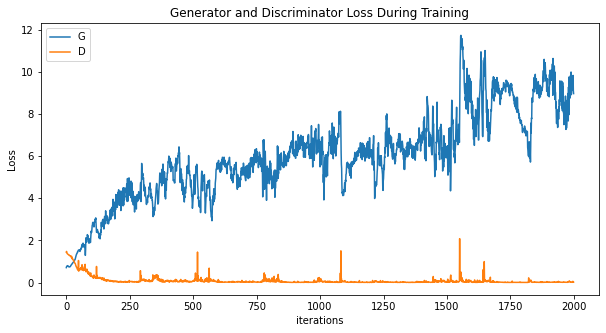

In [30]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
torch.save({
            'epoch': epoch,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict(),
            'loss': errG.item(),
            'whole_model': netG}, 
            './motif_generator_checkpoint.pt')

In [34]:
torch.save({
            'epoch': epoch,
            'model_state_dict': netD.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict(),
            'loss': errD.item(),
            'whole_model': netD}, 
            './motif_discriminator_checkpoint.pt')

# Synthesize Heterodimeric Motifs

In [118]:
fixed_noise = torch.randn(len(test_family_code), 32).float().to(device)
test_family_tsr = torch.from_numpy(test_family_code).float().to(device)
test_motif1_tsr = torch.from_numpy(test_motif1_code).float().to(device)
test_motif2_tsr = torch.from_numpy(test_motif2_code).float().to(device)

In [119]:
with torch.no_grad():
    generated_hmotif = netG(fixed_noise, test_motif1_tsr, test_motif1_tsr, test_family_tsr).detach().cpu()

In [120]:
norm_generated_hmotif = [generated_hmotif[i].T/np.repeat(generated_hmotif[i].T.sum(-1)[:, np.newaxis],4, -1) for i in range(len(generated_hmotif))]

In [121]:
def build_df4logmarker(seq_mat):
    df = pd.DataFrame(columns=['pos', 'A', 'C', 'G', 'T'])
    df['pos'] = np.arange(len(seq_mat))
    df['A'] = seq_mat[:, 0]
    df['C'] = seq_mat[:, 1]
    df['G'] = seq_mat[:, 2]
    df['T'] = seq_mat[:, 3]
    df.set_index(["pos"], inplace=True)
    return df

<IPython.core.display.Javascript object>


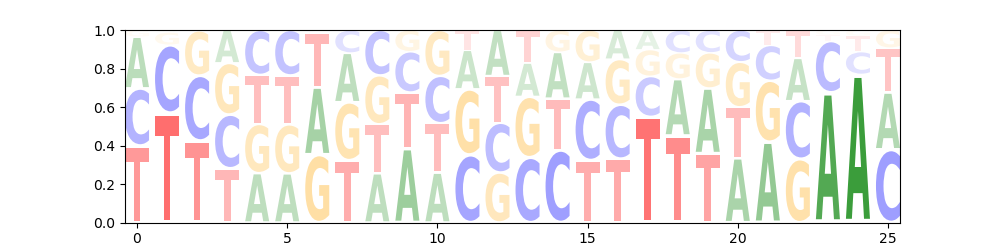

<IPython.core.display.Javascript object>


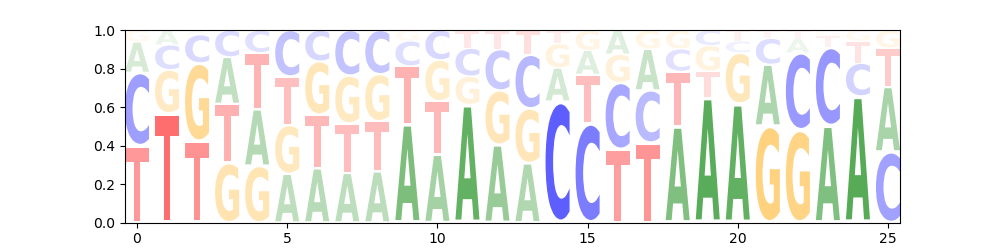

<IPython.core.display.Javascript object>


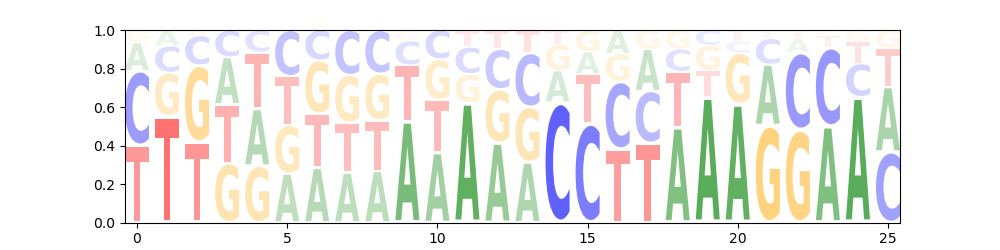

<IPython.core.display.Javascript object>


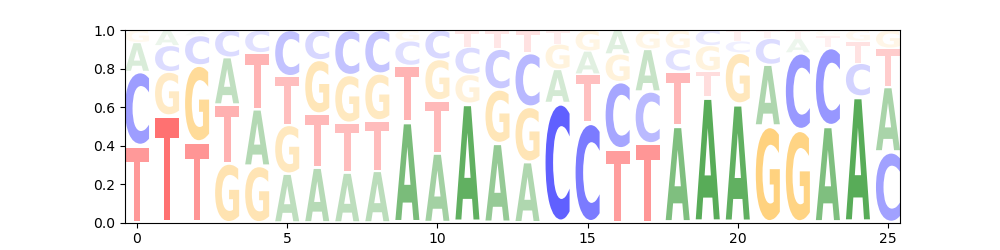

In [131]:
for i in range(len(generated_hmotif)):
    true_dimer_df = build_df4logmarker(norm_generated_hmotif[i][8:34])
    logo = logomaker.Logo(true_dimer_df,
                             width=.8,
                             vpad=.05,
                             fade_probabilities=True,
                             stack_order='small_on_top')